# submission version

In [1]:
import joblib

sa_vec = joblib.load("../builds/sa_vectorizer.joblib")
esa_vec = joblib.load("../builds/esa_vectorizer.joblib")

print("sa vectorizer vocab size:", len(sa_vec.get_feature_names_out()))
print("esa vectorizer vocab size:", len(esa_vec.get_feature_names_out()))

sa vectorizer vocab size: 10000
esa vectorizer vocab size: 10000


/home/rc/version-tab/.pixi/envs/default/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rc/version-tab/.pixi/envs/default/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [2]:
def load_txt_lines(path):
    with open(path, encoding="utf-8") as f:
        return [line.strip() for line in f if line.strip()]

train_medium = load_txt_lines("../math/train-medium/arithmetic__div.txt")
# Similarly load train-medium, train-hard, test, etc.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# For standalone TF‑IDF transformation:
X_train_sa = sa_vec.transform(train_medium)
X_train_esa = esa_vec.transform(train_medium)

print("SA matrix shape:", X_train_sa.shape)
print("ESA matrix shape:", X_train_esa.shape)

SA matrix shape: (1333332, 10000)
ESA matrix shape: (1333332, 10000)


In [7]:
def load_lines(path):
    return [line.strip() for line in open(path, encoding="utf-8") if line.strip()]

train = load_lines("../math/train-medium/polynomials__collect.txt")  # adjust paths
test = load_lines("../math/interpolate/calculus__differentiate.txt")

print("Train count:", len(train), "Test count:", len(test))

Train count: 1333332 Test count: 20000


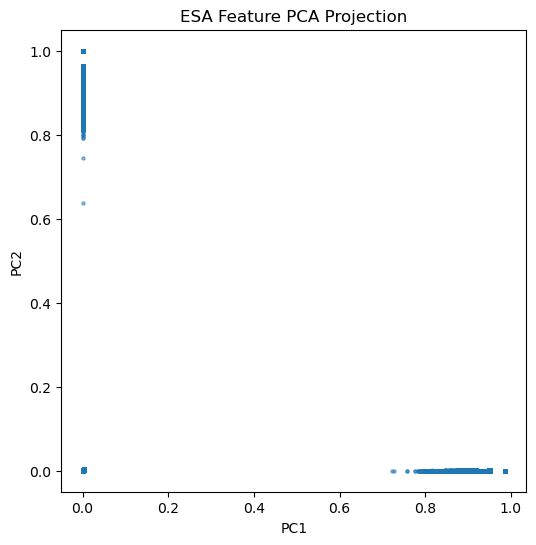

In [5]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Reduce ESA features to 2D
svd = TruncatedSVD(n_components=2)
coords = svd.fit_transform(X_train_esa)

plt.figure(figsize=(6, 6))
plt.scatter(coords[:, 0], coords[:, 1], s=5, alpha=0.5)
plt.title("ESA Feature PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

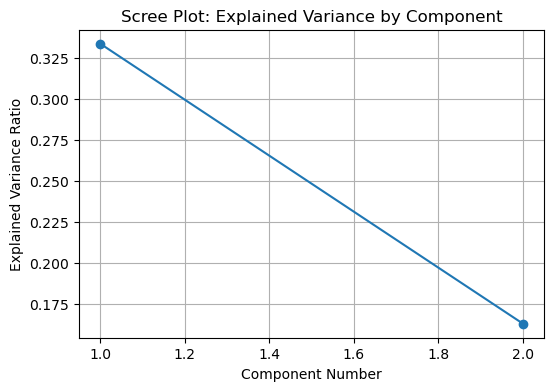

In [8]:
# Test for variance
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

svd = TruncatedSVD(n_components=2)
coords = svd.fit_transform(X_train_esa)
ratios = svd.explained_variance_ratio_

plt.figure(figsize=(6,4))
plt.plot(range(1, len(ratios)+1), ratios, 'o-')
plt.title("Scree Plot: Explained Variance by Component")
plt.xlabel("Component Number")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

In [9]:
import numpy as np

components = svd.components_
feature_names = esa_vec.get_feature_names_out()

for idx, pc in enumerate(components):
    top_idx = np.argsort(np.abs(pc))[::-1][:10]
    print(f"Top features for PC{idx + 1}:")
    for i in top_idx:
        print(f"  {feature_names[i]} (loading {pc[i]:.3f})")
    print()

Top features for PC1:
  divided (loading 0.987)
  calculate (loading 0.161)
  10 (loading 0.003)
  11 (loading 0.003)
  12 (loading 0.002)
  13 (loading 0.002)
  14 (loading 0.002)
  15 (loading 0.002)
  16 (loading 0.002)
  17 (loading 0.002)

Top features for PC2:
  divide (loading 1.000)
  10 (loading 0.003)
  11 (loading 0.003)
  12 (loading 0.003)
  13 (loading 0.002)
  14 (loading 0.002)
  15 (loading 0.002)
  16 (loading 0.002)
  17 (loading 0.002)
  18 (loading 0.002)



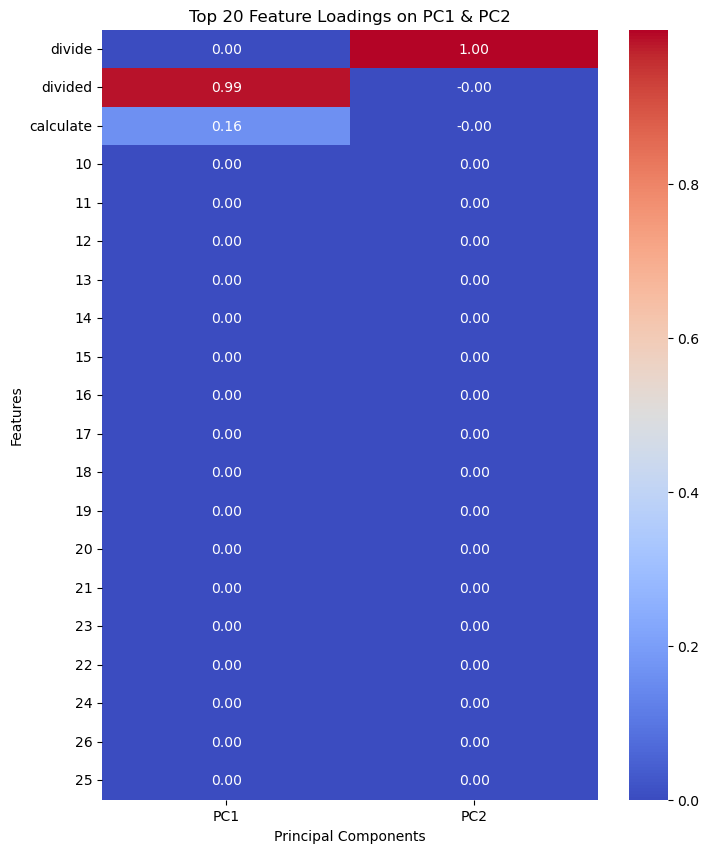

In [10]:
import pandas as pd
import seaborn as sns

loadings = svd.components_.T  # shape: (n_features × 2)
feature_names = esa_vec.get_feature_names_out()  # your concept names

df_load = pd.DataFrame(loadings, index=feature_names, columns=["PC1", "PC2"])
top = df_load.abs().sum(axis=1).sort_values(ascending=False).head(20)
df_top = df_load.loc[top.index]

plt.figure(figsize=(8,10))
sns.heatmap(df_top, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Top 20 Feature Loadings on PC1 & PC2")
plt.xlabel("Principal Components")
plt.ylabel("Features")
plt.show()

In [11]:
import glob
import os

label_paths = glob.glob("../math/interpolate/*.txt")
labels = []

for path in label_paths:
    label = os.path.basename(os.path.dirname(path))
    labels.append(label)

print(f"Found {len(labels)} labels from interpolate/")

Found 56 labels from interpolate/


In [12]:
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer

# Check working directory
print("Current working directory:", os.getcwd())

# List concept files
paths = glob.glob("../math/train-medium/*.txt")
print("Found concept files:", paths)

# Load into docs list
docs = []
for path in paths:
    with open(path, encoding='utf-8') as f:
        docs.append(f.read())

print("\nLoaded docs count:", len(docs))

# Preview first document
if docs:
    print("\nPreview:", docs[0][:200], "…")

# Build TF-IDF model
concept_vec = TfidfVectorizer(stop_words='english', max_features=10000)
X_concepts = concept_vec.fit_transform(docs)
print("\nConcept matrix shape:", X_concepts.shape)

Current working directory: /home/rc/version-tab/notebooks
Found concept files: ['../math/train-medium/numbers__place_value_composed.txt', '../math/train-medium/arithmetic__simplify_surd.txt', '../math/train-medium/arithmetic__mul_div_multiple.txt', '../math/train-medium/calculus__differentiate_composed.txt', '../math/train-medium/probability__swr_p_level_set.txt', '../math/train-medium/numbers__lcm.txt', '../math/train-medium/arithmetic__add_or_sub.txt', '../math/train-medium/numbers__gcd_composed.txt', '../math/train-medium/calculus__differentiate.txt', '../math/train-medium/numbers__is_prime_composed.txt', '../math/train-medium/numbers__round_number.txt', '../math/train-medium/polynomials__add.txt', '../math/train-medium/arithmetic__add_sub_multiple.txt', '../math/train-medium/algebra__polynomial_roots_composed.txt', '../math/train-medium/arithmetic__div.txt', '../math/train-medium/measurement__time.txt', '../math/train-medium/numbers__is_factor.txt', '../math/train-medium/numbers__l

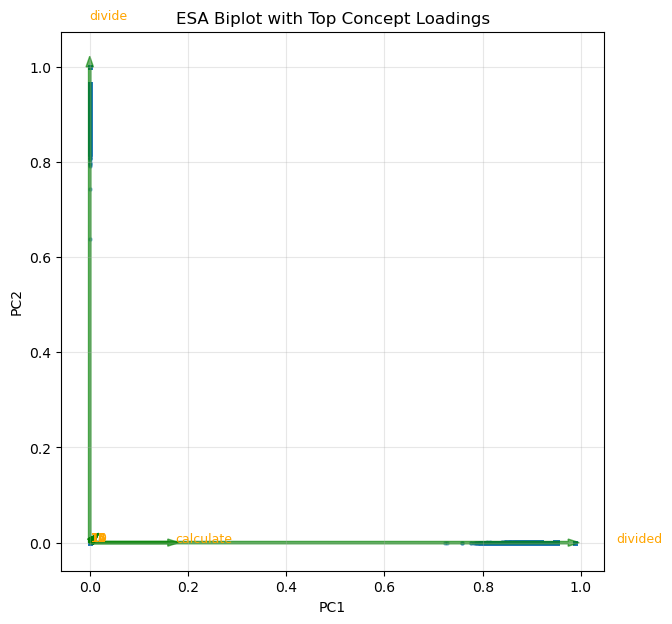

In [13]:
import matplotlib.pyplot as plt

# Select top K features by magnitude
K = 10
scores = coords
loadings = svd.components_.T
mags = np.linalg.norm(loadings, axis=1)
top_features = np.argsort(mags)[::-1][:K]

plt.figure(figsize=(7, 7))
plt.scatter(scores[:, 0], scores[:, 1], s=5, alpha=0.4)

for i in top_features:
    x, y = loadings[i] * np.abs(scores).max(axis=0)
    plt.arrow(0, 0, x, y, color='green', alpha=0.6, width=0.005)
    plt.text(x * 1.1, y * 1.1, feature_names[i], color='orange', fontsize=9)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("ESA Biplot with Top Concept Loadings")
plt.grid(alpha=0.3)
plt.show()

In [14]:
import glob
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

def load_docs_and_labels(base_path):
    paths = glob.glob(os.path.join(base_path, "*.txt"))
    docs = []
    labels = []

    for path in paths:
        with open(path, encoding='utf-8') as f:
            docs.append(f.read())

        # Extract label from file name prefix before '__'
        filename = os.path.basename(path)
        label = filename.split("__")[0]
        labels.append(label)

    print(f"Loaded {len(docs)} docs from {base_path}")
    return docs, labels

# === Train set ===
train_docs, train_labels = load_docs_and_labels("../math/train-medium")

# Fit TF-IDF on train
concept_vec = TfidfVectorizer(stop_words='english', max_features=10000)
X_train = concept_vec.fit_transform(train_docs)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_labels)

print("\nTrain matrix shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Label classes:", le.classes_)

# === Interpolate set ===
interpolate_docs, interpolate_labels = load_docs_and_labels("../math/interpolate")

X_interpolate = concept_vec.transform(interpolate_docs)
y_interpolate = le.transform(interpolate_labels)

print("\nInterpolate matrix shape:", X_interpolate.shape)
print("y_interpolate shape:", y_interpolate.shape)

# === Extrapolate set ===
extrapolate_docs, extrapolate_labels = load_docs_and_labels("../math/extrapolate")

X_extrapolate = concept_vec.transform(extrapolate_docs)
y_extrapolate = le.transform(extrapolate_labels)

print("\nExtrapolate matrix shape:", X_extrapolate.shape)
print("y_extrapolate shape:", y_extrapolate.shape)

# === Final shape summary ===
print("\nFinal shape summary:")
print("Train X:", X_train.shape, "Train y:", y_train.shape)
print("Interpolate X:", X_interpolate.shape, "Interpolate y:", y_interpolate.shape)
print("Extrapolate X:", X_extrapolate.shape, "Extrapolate y:", y_extrapolate.shape)

Loaded 56 docs from ../math/train-medium

Train matrix shape: (56, 10000)
y_train shape: (56,)
Label classes: ['algebra' 'arithmetic' 'calculus' 'comparison' 'measurement' 'numbers'
 'polynomials' 'probability']
Loaded 56 docs from ../math/interpolate

Interpolate matrix shape: (56, 10000)
y_interpolate shape: (56,)
Loaded 15 docs from ../math/extrapolate

Extrapolate matrix shape: (15, 10000)
y_extrapolate shape: (15,)

Final shape summary:
Train X: (56, 10000) Train y: (56,)
Interpolate X: (56, 10000) Interpolate y: (56,)
Extrapolate X: (15, 10000) Extrapolate y: (15,)


In [55]:
import numpy as np
import tensorflow as tf
import random

# Set seeds
np.random.seed(578)
tf.random.set_seed(578)
random.seed(578)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

basemodel = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')
], name= "version-tab")

basemodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

basemodel.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

/home/rc/version-tab/.pixi/envs/default/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 0.1070 - loss: 2.0806 - val_accuracy: 0.0833 - val_loss: 2.0814
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4650 - loss: 2.0573 - val_accuracy: 0.1667 - val_loss: 2.0767
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6383 - loss: 2.0376 - val_accuracy: 0.0000e+00 - val_loss: 2.0717
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.6383 - loss: 2.0117 - val_accuracy: 0.1667 - val_loss: 2.0668
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6686 - loss: 1.9925 - val_accuracy: 0.1667 - val_loss: 2.0618
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6941 - loss: 1.9745 - val_accuracy: 0.1667 - val_loss: 2.0567
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7604 - loss: 1.9473 - val_accuracy: 0.1667 - val_loss: 2.0511
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7093 - loss: 1.9207 - val_accuracy: 0.1667 - val_l

In [56]:
print("Train shape:", X_train.shape)
print("Test shape:", X_interpolate.shape)

Train shape: (56, 10000)
Test shape: (56, 10000)


In [57]:
# Evaluate on interpolate
interpolate_loss, interpolate_acc = basemodel.evaluate(X_interpolate, y_interpolate, verbose=1)
print(f"\nInterpolate set accuracy: {interpolate_acc:.4f}")

# Evaluate on extrapolate
extrapolate_loss, extrapolate_acc = basemodel.evaluate(X_extrapolate, y_extrapolate, verbose=1)
print(f"\nExtrapolate set accuracy: {extrapolate_acc:.4f}")


# # --------------------------------------------------------------------------

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6548 - loss: 1.8653

Interpolate set accuracy: 0.6071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7333 - loss: 1.8050

Extrapolate set accuracy: 0.7333


In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_interpolate = basemodel.predict(X_interpolate)
y_pred_interpolate_classes = np.argmax(y_pred_interpolate, axis=1)

print("\nInterpolate classification report:")
print(classification_report(y_interpolate, y_pred_interpolate_classes, target_names=le.classes_))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

Interpolate classification report:
              precision    recall  f1-score   support

     algebra       1.00      0.62      0.77         8
  arithmetic       1.00      0.67      0.80         9
    calculus       1.00      0.50      0.67         2
  comparison       1.00      0.12      0.22         8
 measurement       1.00      0.50      0.67         2
     numbers       0.44      1.00      0.61        17
 polynomials       1.00      0.12      0.22         8
 probability       1.00      1.00      1.00         2

    accuracy                           0.61        56
   macro avg       0.93      0.57      0.62        56
weighted avg       0.83      0.61      0.57        56



In [59]:
loss, acc = basemodel.evaluate(X_interpolate, y_interpolate)
print(f"\nInterpolate set accuracy: {acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6548 - loss: 1.8653

Interpolate set accuracy: 0.6071


In [60]:
y_pred_probs = basemodel.predict(X_interpolate)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


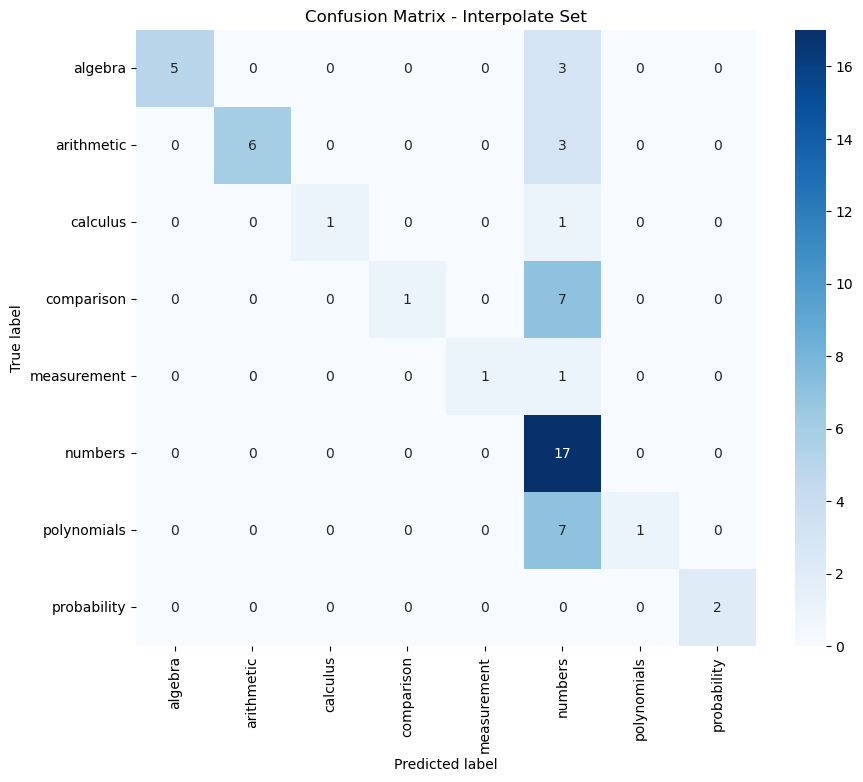

In [61]:
cm = confusion_matrix(y_interpolate, y_pred_classes, labels=range(len(le.classes_)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Interpolate Set")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


# # ------------------------------------------------------------------------

In [62]:
loss, acc = basemodel.evaluate(X_extrapolate, y_extrapolate)
print(f"\nExtrapolate set accuracy: {acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7333 - loss: 1.8050

Extrapolate set accuracy: 0.7333


In [63]:
y_pred_probs = basemodel.predict(X_extrapolate)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [64]:
print("\nExtrapolate classification report:")
print(classification_report(
    y_extrapolate, y_pred_classes,
    labels=range(len(le.classes_)),
    target_names=le.classes_,
    zero_division=0
))


Extrapolate classification report:
              precision    recall  f1-score   support

     algebra       1.00      1.00      1.00         1
  arithmetic       1.00      0.67      0.80         6
    calculus       0.00      0.00      0.00         0
  comparison       1.00      0.33      0.50         3
 measurement       1.00      1.00      1.00         1
     numbers       0.33      1.00      0.50         2
 polynomials       0.00      0.00      0.00         0
 probability       1.00      1.00      1.00         2

    accuracy                           0.73        15
   macro avg       0.67      0.62      0.60        15
weighted avg       0.91      0.73      0.75        15



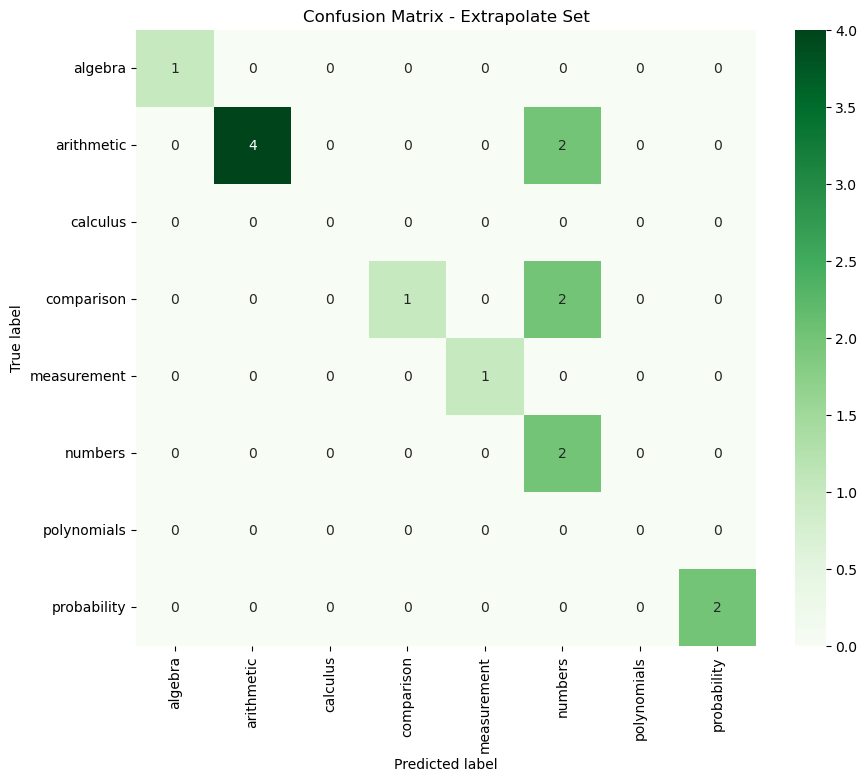

In [65]:
cm = confusion_matrix(y_extrapolate, y_pred_classes, labels=range(len(le.classes_)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Extrapolate Set")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


# # --------------------------------------------------------------------------------

In [66]:
import os
from glob import glob

print("Working directory:", os.getcwd())
print("Top-level items:", os.listdir("."))

matches = glob("**/*", recursive=True)
print("All files and folders:")
for item in matches:
    print("  ", item)

Working directory: /home/rc/version-tab/notebooks
Top-level items: ['notebook.ipynb', 'prototype.ipynb', 'basemodel.ipynb', 'model.ipynb', '.ipynb_checkpoints']
All files and folders:
   notebook.ipynb
   prototype.ipynb
   basemodel.ipynb
   model.ipynb


In [67]:
from transformers import TFT5ForConditionalGeneration

with open("../models/basemodel_summary.txt", "w") as f:
    def print_to_file(*args, **kwargs):
        print(*args, **kwargs, file=f)

    basemodel.summary(print_fn=print_to_file)

print("Model summary saved to basemodel_summary.txt")

Model summary saved to basemodel_summary.txt


In [68]:
import pandas as pd

y_pred_probs_interpolate = basemodel.predict(X_interpolate)
y_pred_classes_interpolate = np.argmax(y_pred_probs_interpolate, axis=1)

true_labels_interpolate = le.inverse_transform(y_interpolate)
pred_labels_interpolate = le.inverse_transform(y_pred_classes_interpolate)

df_interpolate = pd.DataFrame({
    "true_label": true_labels_interpolate,
    "predicted_label": pred_labels_interpolate
})

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [69]:
y_pred_probs_extrapolate = basemodel.predict(X_extrapolate)
y_pred_classes_extrapolate = np.argmax(y_pred_probs_extrapolate, axis=1)

true_labels_extrapolate = le.inverse_transform(y_extrapolate)
pred_labels_extrapolate = le.inverse_transform(y_pred_classes_extrapolate)

df_extrapolate = pd.DataFrame({
    "true_label": true_labels_extrapolate,
    "predicted_label": pred_labels_extrapolate
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [70]:
import os
os.makedirs("../predictions", exist_ok=True)

df_interpolate.to_csv("../predictions/basemodel_predictions.csv", index=False)
print("Interpolate predictions saved.")

df_extrapolate.to_csv("../predictions/basemodel_predictions2.csv", index=False)
print("Extrapolate predictions saved.")

Interpolate predictions saved.
Extrapolate predictions saved.


In [71]:
import os
import pandas as pd

# Make sure predictions directory exists
os.makedirs("../predictions", exist_ok=True)

# -------------------------------
# Interpolate predictions
# -------------------------------
y_pred_probs_interpolate = basemodel.predict(X_interpolate)
y_pred_classes_interpolate = np.argmax(y_pred_probs_interpolate, axis=1)

true_labels_interpolate = le.inverse_transform(y_interpolate)
pred_labels_interpolate = le.inverse_transform(y_pred_classes_interpolate)

df_interpolate = pd.DataFrame({
    "true_label": true_labels_interpolate,
    "predicted_label": pred_labels_interpolate
})
df_interpolate["correct"] = df_interpolate["true_label"] == df_interpolate["predicted_label"]

# Save interpolate predictions
output_file_interpolate = "../predictions/basemodel_predictions.csv"
df_interpolate.to_csv(output_file_interpolate, index=False)
print(f"Interpolate predictions saved to: {output_file_interpolate}")

# -------------------------------
# Extrapolate predictions
# -------------------------------
y_pred_probs_extrapolate = basemodel.predict(X_extrapolate)
y_pred_classes_extrapolate = np.argmax(y_pred_probs_extrapolate, axis=1)

true_labels_extrapolate = le.inverse_transform(y_extrapolate)
pred_labels_extrapolate = le.inverse_transform(y_pred_classes_extrapolate)

df_extrapolate = pd.DataFrame({
    "true_label": true_labels_extrapolate,
    "predicted_label": pred_labels_extrapolate
})
df_extrapolate["correct"] = df_extrapolate["true_label"] == df_extrapolate["predicted_label"]

# Save extrapolate predictions
output_file_extrapolate = "../predictions/basemodel_predictions2.csv"
df_extrapolate.to_csv(output_file_extrapolate, index=False)
print(f"Extrapolate predictions saved to: {output_file_extrapolate}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Interpolate predictions saved to: ../predictions/basemodel_predictions.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Extrapolate predictions saved to: ../predictions/basemodel_predictions2.csv


In [72]:
test = pd.read_csv("../predictions/basemodel_predictions.csv")
test2 = pd.read_csv("../predictions/basemodel_predictions2.csv")

In [73]:
print(test.head())

    true_label predicted_label  correct
0      numbers         numbers     True
1   arithmetic      arithmetic     True
2   arithmetic      arithmetic     True
3     calculus         numbers    False
4  probability     probability     True


In [74]:
print(test2.head())

    true_label predicted_label  correct
0   arithmetic      arithmetic     True
1  probability     probability     True
2      numbers         numbers     True
3   arithmetic         numbers    False
4      algebra         algebra     True


In [75]:
# Calculate accuracies
acc_interpolate = test["correct"].mean() * 100
acc_extrapolate = test2["correct"].mean() * 100

# Print results
print(f"Interpolate accuracy: {acc_interpolate:.2f}%")
print(f"Extrapolate accuracy: {acc_extrapolate:.2f}%")

Interpolate accuracy: 60.71%
Extrapolate accuracy: 73.33%


In [76]:
from IPython.display import Markdown

with open("../models/basemodel_summary.txt", "r") as f:
    summary_text = f.read()

display(Markdown(f"```\n{summary_text}\n```"))

```
Model: "version-tab"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 3,843,482 (14.66 MB)
 Trainable params: 1,281,160 (4.89 MB)
 Non-trainable params: 0 (0.00 B)
 Optimizer params: 2,562,322 (9.77 MB)


```

If this bores you I left an easter egg here for you. enjoy: [easter egg](https://web.archive.org/web/19981202230410id_/http://www.google.com/)